In [3]:
import os
import sys
sys.path.append(os.environ['COOPERHEWITT_ROOT'] + '/src')
sys.path.append(os.environ['COOPERHEWITT_ROOT'] + '/src/apps')

In [8]:
import os
import pandas as pd
import plots
import ch_pen as chp
import ch_metaobjects as chm
%matplotlib inline

In [5]:
### Objects/Files
pen  = chp.Pen()
meta = chm.MetaObjectStore()
dsp  = plots.Display()
### Load serialized data
export_path  = os.environ['COOPERHEWITT_ROOT'] + '/export/'
df_objects   = pd.read_pickle(export_path + "collection_objects.pkl")
df_meta      = pd.read_pickle(export_path + 'penmeta_spark.pkl')
df_bundleseq = pd.read_pickle(export_path + "pen_bundle_seq.pkl")
### site information
site_rooms = meta.museum.site_rooms()

Page Response=200, Num Records=22, Pages=1


In [6]:
### Calculate Metrics
# time based
nscans_per_month   = pen.df_pen.groupby(['month'], sort=True).size()
nscans_per_year    = pen.df_pen.groupby(['year'], sort=True).size()
nscans_per_days    = pen.df_pen.groupby(['day'], sort=True).size()
nscans_per_dow     = pen.df_pen.groupby(['dow'], sort=True).size()
nscans_per_hour    = pen.df_pen.groupby(['hour'], sort=True).size()
nscans_per_quarter = pen.df_pen.groupby(['quarter'], sort=True).size()
nscans_per_exhibit = pen.df_pen.groupby(['during_exhibition'], sort=True).size()
nscans_per_exhibit.index = ['non-exhibitions', 'exhibitions']
# specific cases where there are tags done after hours
nscans_per_close   = pen.df_pen.groupby(['tagged_after_close'], sort=True).size()
nscans_per_close.index   = ['open hours', 'after hours']
# popular floors
nscans_per_floor   = df_meta['room_floor'].value_counts()
nscans_per_floori  = nscans_per_floor.sort_values(ascending=False)
nscans_per_floori.index = nscans_per_floori.index.astype(int)
# popular rooms
nscans_per_room = meta.df_locations['room_name'].value_counts()
nscans_per_room = nscans_per_room.sort_values(ascending=False)
nscans_per_room.index = nscans_per_room.index.astype(int)
nscans_per_roomi = (nscans_per_room)[:7].sort_values(ascending=False)
# popular spots
nscans_per_spot = meta.df_locations['spot_name'].value_counts()
nscans_per_spot = nscans_per_spot.sort_values(ascending=False)[:7]
nscans_per_spot.index = nscans_per_spot.index.map(lambda x: (''.join(x.split(',')[2:]).strip()  ))
# where to people first go
df_bundle_firstitem = df_bundleseq.apply(lambda item: item[0][1])
df_freq_firstitem   = df_bundle_firstitem.value_counts().sort_values(ascending=False)
df_freq_firstitem   = df_freq_firstitem.reset_index()
df_freq_firstitem   = df_freq_firstitem.rename(columns={'index':'id', 0:'counts'})
df_freq_meta = pd.DataFrame(df_freq_firstitem, columns=['id', 'counts'])\
              .merge(df_objects)[['id', 'counts', 'department_id', 'type', 'title']]
df_freq_meta = df_freq_meta.merge(meta.df_locations, right_on='refers_to_object_id', left_on='id')\
              [['id', 'room_name', 'spot_name', 'type', 'type', 'counts']]
nroomscans_first_tag = df_freq_meta.groupby('room_name')['counts'].sum().sort_values(ascending=False)[:7]
# what are the high capacity rooms
site_rooms.count_spots   = site_rooms.count_spots.astype(int)
site_rooms.count_objects = site_rooms.count_objects.astype(int)
df_rooms = site_rooms.sort_values(['count_objects', 'count_spots'], ascending=False)
df_rooms.index = df_rooms.name
nhighcap_rooms = df_rooms['count_objects'][:7]

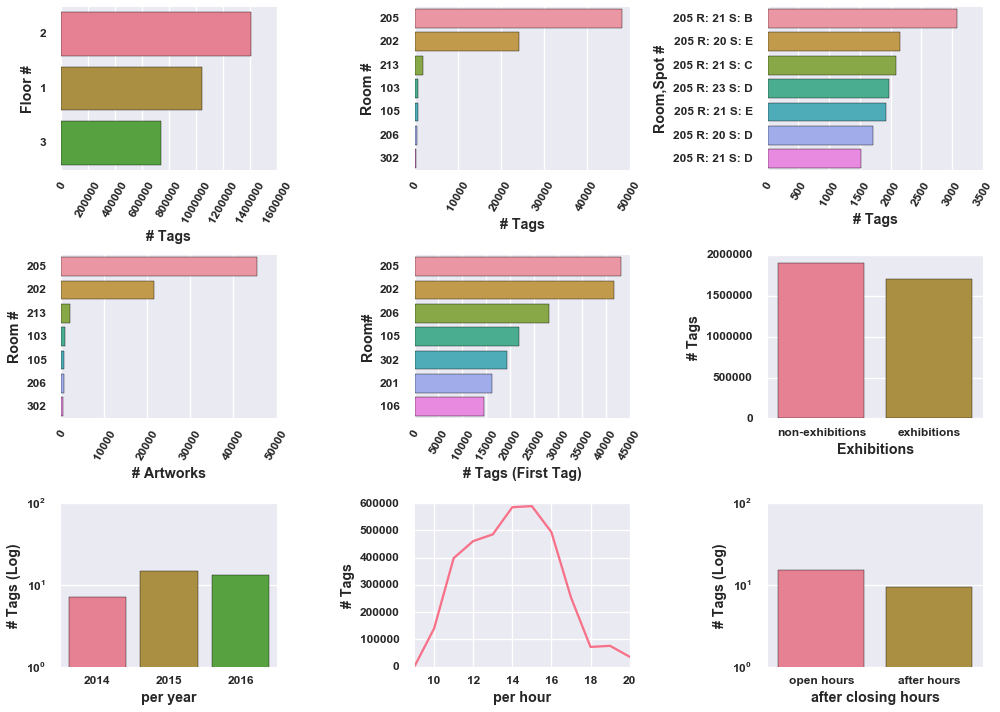

In [9]:
### Explore
params = [
    {'frame': nscans_per_floori,    'xlabel': '# Tags',       
     'ylabel': 'Floor #',           'type': 'hbar', 'rot': 60},
    {'frame': nscans_per_roomi,     'xlabel': '# Tags',       
     'ylabel': 'Room #',            'type': 'hbar', 'rot': 60},
    {'frame': nscans_per_spot,      'xlabel': '# Tags',       
     'ylabel': 'Room,Spot #',       'type': 'hbar', 'rot':60},
    {'frame': nhighcap_rooms,       'xlabel': '# Artworks',   
     'ylabel': 'Room #',            'type': 'hbar', 'rot':60},
    {'frame': nroomscans_first_tag, 'xlabel': '# Tags (First Tag)', 
     'ylabel': 'Room#',             'type': 'hbar', 'rot':60},
    {'frame': nscans_per_exhibit,   'xlabel': 'Exhibitions',  
     'ylabel': '# Tags',            'type': 'bar'},
    {'frame': nscans_per_year,      'xlabel': "per year",
     'ylabel': '# Tags',            'type': 'bar', 'transform': 'Log'},
    {'frame': nscans_per_hour,      'xlabel': "per hour",     
     'ylabel': '# Tags',            'limits': (9,20)},
    {'frame': nscans_per_close,     'xlabel': "after closing hours",
     'ylabel': '# Tags',            'type': 'bar', 'transform': 'Log'}
]

dsp.create_subplots( params, (3, 3, (14,10)), os.environ['COOPERHEWITT_ROOT'] + '/plots/pen_eda_full.png')
#dsp.create_subplots( params, (2, 3, (14,7)), os.environ['COOPERHEWITT_ROOT'] + '/plots/pen_eda_basic.png')